## Imports

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shap
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier, MLPRegressor
from keras.models import Sequential, Model
from keras.layers import Dense,Activation,Dropout, Flatten, Concatenate, concatenate, Input, Lambda
# from keras.layers.embeddings import Embedding
from keras.layers.normalization import batch_normalization 
from keras.utils import np_utils
from tqdm import tqdm
import ipywidgets as widgets

## Util Functions

In [ ]:
# def convert_to_int()

def get_reshape(row):
    # print(row)
    return np.fromstring(row['grid'].replace('\n','')
                                    .replace('[','')
                                    .replace(']','')
                                    .replace('  ',' '), sep=' ').reshape(row['grid_rows'],row['grid_columns'])

def convert_obs(df):
    return df['observation'].apply(lambda x: 
                           np.fromstring(
                               x.replace('\n','')
                                .replace('[','')
                                .replace(']','')
                                .replace('  ',' '), sep=' '))

def gen_heatmap(df,f, ax):
    df = df.reset_index()
    x_array = df['x'].to_numpy()
    y_array =df['y'].to_numpy()
    grid = np.zeros((df['grid_rows'][0],df['grid_columns'][0]))
    for i, j in zip(y_array,x_array):
        grid[i,j]+=1
    heat =sns.heatmap(grid,cmap='viridis',alpha =0.6,zorder=2,ax=ax)
    my_image = mpimg.imread(f)
    # plt.imshow(my_image)
    plt.title(df['experiment'][0])
    ax.heat.imshow(my_image,aspect=heat.get_aspect(),extent= heat.get_xlim() + heat.get_ylim(),zorder=1)
    # plt.close()
    # return heat

def keras_classifier(n_inputs,n_outputs):
    model = Sequential()
    model.add(Dense(1000, input_dim= n_inputs, activation='relu'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(300, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model



## Data Handling

### Reading in the data 

In [ ]:
df1 = pd.read_csv('./data/data.csv')
df = pd.read_csv('./data/data_policy_switching.csv')
df.describe()

### Data Manipulation


In [ ]:
# Modify the grid to be a correct numpy array representing the level
df1['grid'] = df1[['grid','grid_rows','grid_columns']].apply(lambda x: get_reshape(x),axis=1)
df['grid'] = df[['grid','grid_rows','grid_columns']].apply(lambda x: get_reshape(x),axis=1)

# format the observation space into numpy array
df1['observation'] = convert_obs(df1)
df['observation'] = convert_obs(df)

# Shuffle the data 
df1 = df1.sample(frac=1)
df = df.sample(frac=1)
df.head()

In [ ]:
# split the observation into seperate columns
# observations = [dist_monster, dist_treaure, safe_dist_teasure, dist_potion, safe_dist_potion, dist_exit, safe_dist_exit, HP]
obs = ['dist_monster', 'dist_treaure', 'safe_dist_teasure', 'dist_potion', 'safe_dist_potion', 'dist_exit', 'safe_dist_exit', 'HP']

df1[obs] = pd.DataFrame(df1['observation'].to_list(), index= df1.index)
df[obs] = pd.DataFrame(df['observation'].to_list(), index= df.index)
df1.describe()


## Creating the dataset

In [ ]:
data = df[['dist_monster', 'dist_treaure', 'safe_dist_teasure', 'dist_potion', 'safe_dist_potion', 'dist_exit', 'safe_dist_exit', 'HP', 'action']]
data

In [ ]:
# data[obs] = (df[obs]-df[obs].mean())/df[obs].std()
y_data = pd.get_dummies(df['action'])
print(y_data)

In [ ]:
sns.pairplot(data=data, hue = 'action')

In [ ]:
x_data = data[obs].to_numpy()
y_data = data['action']
print(y_data)

### Split data

In [ ]:
x_train, x_test,y_train, y_test = train_test_split(x_data,y_data,test_size=.2, random_state=42)

### create and train model (sklearn logistic regression)

In [ ]:
model_LG = sklearn.linear_model.LogisticRegression(max_iter=100000000, tol=1e-12)
model_LG.fit(x_train,y_train)
model_LG.score(x_test,y_test)

In [ ]:
# nn = MLPClassifier(solver="adam",alpha=1e-0001,hidden_layer_sizes=(8,8,8),random_state=42, max_iter=10000000000000)
# nn.fit(data[obs].values,data['action'].values)
# nn.score(x_test,y_test)

nn = MLPClassifier(solver="adam",alpha=1e-0001,hidden_layer_sizes=(20,20,20),random_state=42, max_iter=10000000000000)
nn.fit(df[obs].values,df['action'].values)
nn.score(df[obs].values,df['action'].values)

In [ ]:
nn1 = MLPRegressor(alpha=1e-1, hidden_layer_sizes=(8,8,8), random_state=0, max_iter=1000000000)
# nn1.fit(df[obs],y_train)

In [ ]:
explainerKernel = shap.KernelExplainer(nn.predict_proba,data[obs])
shap_vals = explainerKernel.shap_values(x_test)
# shap.force_plot(explainer.expected_value[0],shap_vals[0],x_test)

In [ ]:
# print the JS visualization code to the notebook
shap.initjs()
# shap.force_plot(explainer.expected_value[0],shap_vals[0],x_test)
shap.summary_plot(shap_vals,feature_names=data[obs].columns, class_names= y_data.columns)

In [ ]:
# Create the list of all labels for the drop down list
list_of_labels = y_data.columns.to_list()

# Create a list of tuples so that the index of the label is what is returned
tuple_of_labels = list(zip(list_of_labels, range(len(list_of_labels))))

# Create a widget for the labels and then display the widget
current_label = widgets.Dropdown(options=tuple_of_labels,
                              value=0,
                              description='Select Label:'
                              )

# Display the dropdown list (Note: access index value with 'current_label.value')
current_label

In [ ]:

shap.summary_plot(shap_values = shap_vals[current_label.value],feature_names= data[obs].columns)

In [ ]:
# plot for all 4 classes

In [ ]:
shap.bar_plot(shap_values = shap_vals[current_label.value])

In [ ]:
explainer = shap.Explainer(nn.predict_proba, data[obs])
shap_values = explainer(data[obs])

In [ ]:
shap.summary_plot(shap_values[current_label.value])


## Keras and big dataset

In [ ]:
ldata =['dist_monster', 'dist_treaure', 'safe_dist_teasure', 'dist_potion', 'safe_dist_potion', 'dist_exit', 'safe_dist_exit', 'HP', 'action']
data = pd.concat([df[ldata],df1[ldata]], ignore_index=True)
data

In [ ]:
x_data = data[obs]
y_data = pd.get_dummies(data['action'])
y_data.head()


In [ ]:
nn = MLPClassifier(solver="adam",alpha=1e-0001,hidden_layer_sizes=(20,20,20),random_state=42, max_iter=10000000000000)
nn.fit(data[obs].values,data['action'].values)
nn.score(data[obs].values,data['action'].values)

In [ ]:
model = keras_classifier(len(x_data.columns), len(y_data.columns))
model.summary()

In [ ]:
model.fit(x_data.values,y_data.values,batch_size=20, epochs= 10, verbose=1)

In [ ]:
def f(X):
    return model.predict([X[:,i] for i in range(X.shape[1])])

In [ ]:
Kernel_explainer = shap.KernelExplainer(model.predict, x_data.iloc[:50,:])
# deep_explainer = shap.DeepExplainer(model,x_data.iloc[:50,:])
exact_explainer = shap.explainers.Exact(model.predict, x_data.iloc[:50,:])
explainer = shap.Explainer(model.predict, x_data.iloc[:100,:])
# Kernel_explainer = shap.KernelExplainer(nn.predict_proba, x_data.iloc[:50,:])
# # deep_explainer = shap.DeepExplainer(model,x_data.iloc[:50,:])
# exact_explainer = shap.explainers.Exact(nn.predict_proba, x_data.iloc[:50,:])
# explainer = shap.Explainer(nn.predict_proba, x_data.iloc[:100,:])

In [98]:
kernel_shap_values = Kernel_explainer.shap_values(X = x_data.iloc[:100,:],nsamples=100)
explainer_shap_values = explainer(x_data.iloc[:100,:])

  0%|          | 0/100 [00:00<?, ?it/s]

26/26 [==============================] - 0s 10ms/step


Exact explainer:   5%|▌         | 5/100 [00:00<?, ?it/s]

27/27 [==============================] - 0s 5ms/step


Exact explainer:   7%|▋         | 7/100 [00:15<02:17,  1.48s/it]

28/28 [==============================] - 0s 5ms/step


Exact explainer:   8%|▊         | 8/100 [00:19<04:00,  2.61s/it]

26/26 [==============================] - 0s 4ms/step


Exact explainer:   9%|▉         | 9/100 [00:22<03:39,  2.41s/it]

26/26 [==============================] - 0s 4ms/step


Exact explainer:  10%|█         | 10/100 [00:24<03:24,  2.27s/it]

28/28 [==============================] - 0s 3ms/step


Exact explainer:  11%|█         | 11/100 [00:27<03:48,  2.56s/it]

27/27 [==============================] - 0s 4ms/step


Exact explainer:  12%|█▏        | 12/100 [00:29<03:38,  2.49s/it]

27/27 [==============================] - 0s 4ms/step


Exact explainer:  13%|█▎        | 13/100 [00:31<03:26,  2.38s/it]

26/26 [==============================] - 0s 2ms/step


Exact explainer:  14%|█▍        | 14/100 [00:33<03:12,  2.23s/it]

28/28 [==============================] - 0s 4ms/step


Exact explainer:  15%|█▌        | 15/100 [00:37<03:44,  2.65s/it]

28/28 [==============================] - 0s 4ms/step


Exact explainer:  16%|█▌        | 16/100 [00:40<03:59,  2.85s/it]

27/27 [==============================] - 0s 5ms/step


Exact explainer:  17%|█▋        | 17/100 [00:42<03:42,  2.68s/it]

27/27 [==============================] - 0s 5ms/step


Exact explainer:  18%|█▊        | 18/100 [00:44<03:22,  2.47s/it]

28/28 [==============================] - 0s 5ms/step


Exact explainer:  19%|█▉        | 19/100 [00:47<03:16,  2.43s/it]

26/26 [==============================] - 0s 3ms/step


Exact explainer:  20%|██        | 20/100 [00:49<03:04,  2.30s/it]

28/28 [==============================] - 0s 5ms/step


Exact explainer:  21%|██        | 21/100 [00:51<02:59,  2.27s/it]

28/28 [==============================] - 0s 3ms/step


Exact explainer:  22%|██▏       | 22/100 [00:53<02:58,  2.29s/it]

27/27 [==============================] - 0s 4ms/step


Exact explainer:  23%|██▎       | 23/100 [00:55<02:52,  2.24s/it]

28/28 [==============================] - 0s 5ms/step


Exact explainer:  24%|██▍       | 24/100 [00:59<03:15,  2.58s/it]

26/26 [==============================] - 0s 4ms/step


Exact explainer:  25%|██▌       | 25/100 [01:01<03:01,  2.42s/it]

26/26 [==============================] - 0s 4ms/step


Exact explainer:  26%|██▌       | 26/100 [01:04<03:10,  2.58s/it]

27/27 [==============================] - 0s 4ms/step


Exact explainer:  27%|██▋       | 27/100 [01:06<02:54,  2.40s/it]

27/27 [==============================] - 0s 6ms/step


Exact explainer:  28%|██▊       | 28/100 [01:08<02:49,  2.35s/it]

26/26 [==============================] - 0s 5ms/step


Exact explainer:  29%|██▉       | 29/100 [01:11<02:59,  2.52s/it]

27/27 [==============================] - 0s 4ms/step


Exact explainer:  30%|███       | 30/100 [01:13<02:49,  2.42s/it]

27/27 [==============================] - 0s 6ms/step


Exact explainer:  31%|███       | 31/100 [01:15<02:45,  2.40s/it]

27/27 [==============================] - 0s 5ms/step


Exact explainer:  32%|███▏      | 32/100 [01:18<02:42,  2.39s/it]

26/26 [==============================] - 0s 6ms/step


Exact explainer:  33%|███▎      | 33/100 [01:21<02:51,  2.55s/it]

28/28 [==============================] - 0s 4ms/step


Exact explainer:  34%|███▍      | 34/100 [01:23<02:43,  2.47s/it]

28/28 [==============================] - 0s 5ms/step


Exact explainer:  35%|███▌      | 35/100 [01:25<02:37,  2.42s/it]

27/27 [==============================] - 0s 4ms/step


Exact explainer:  36%|███▌      | 36/100 [01:27<02:31,  2.36s/it]

28/28 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 37/100 [01:30<02:28,  2.36s/it]

26/26 [==============================] - 0s 3ms/step


Exact explainer:  38%|███▊      | 38/100 [01:32<02:16,  2.20s/it]

26/26 [==============================] - 0s 4ms/step


Exact explainer:  39%|███▉      | 39/100 [01:34<02:12,  2.17s/it]

28/28 [==============================] - 0s 3ms/step


Exact explainer:  40%|████      | 40/100 [01:37<02:33,  2.56s/it]

26/26 [==============================] - 0s 7ms/step


Exact explainer:  41%|████      | 41/100 [01:40<02:28,  2.51s/it]

28/28 [==============================] - 0s 6ms/step


Exact explainer:  42%|████▏     | 42/100 [01:42<02:22,  2.46s/it]

27/27 [==============================] - 0s 5ms/step


Exact explainer:  43%|████▎     | 43/100 [01:44<02:17,  2.42s/it]

26/26 [==============================] - 0s 6ms/step


Exact explainer:  44%|████▍     | 44/100 [01:46<02:12,  2.37s/it]

28/28 [==============================] - 0s 3ms/step


Exact explainer:  45%|████▌     | 45/100 [01:48<02:03,  2.25s/it]

26/26 [==============================] - 0s 4ms/step


Exact explainer:  46%|████▌     | 46/100 [01:51<01:59,  2.21s/it]

26/26 [==============================] - 0s 4ms/step


Exact explainer:  47%|████▋     | 47/100 [01:53<01:59,  2.25s/it]

26/26 [==============================] - 0s 4ms/step


Exact explainer:  48%|████▊     | 48/100 [01:55<01:57,  2.27s/it]

27/27 [==============================] - 0s 6ms/step


Exact explainer:  49%|████▉     | 49/100 [01:58<02:07,  2.50s/it]

28/28 [==============================] - 0s 4ms/step


Exact explainer:  50%|█████     | 50/100 [02:01<02:02,  2.45s/it]

28/28 [==============================] - 0s 5ms/step


Exact explainer:  51%|█████     | 51/100 [02:04<02:19,  2.85s/it]

28/28 [==============================] - 0s 6ms/step


Exact explainer:  52%|█████▏    | 52/100 [02:06<02:06,  2.63s/it]

26/26 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 53/100 [02:09<01:58,  2.51s/it]

28/28 [==============================] - 0s 5ms/step


Exact explainer:  54%|█████▍    | 54/100 [02:11<01:58,  2.57s/it]

26/26 [==============================] - 0s 6ms/step


Exact explainer:  55%|█████▌    | 55/100 [02:14<01:50,  2.46s/it]

27/27 [==============================] - 0s 5ms/step


Exact explainer:  56%|█████▌    | 56/100 [02:16<01:45,  2.39s/it]

27/27 [==============================] - 0s 8ms/step


Exact explainer:  57%|█████▋    | 57/100 [02:18<01:41,  2.36s/it]

26/26 [==============================] - 0s 4ms/step


Exact explainer:  58%|█████▊    | 58/100 [02:20<01:36,  2.31s/it]

26/26 [==============================] - 0s 5ms/step


Exact explainer:  59%|█████▉    | 59/100 [02:23<01:34,  2.30s/it]

27/27 [==============================] - 0s 4ms/step


Exact explainer:  60%|██████    | 60/100 [02:26<01:46,  2.67s/it]

27/27 [==============================] - 0s 5ms/step


Exact explainer:  61%|██████    | 61/100 [02:28<01:40,  2.58s/it]

27/27 [==============================] - 0s 5ms/step


Exact explainer:  62%|██████▏   | 62/100 [02:31<01:36,  2.53s/it]

27/27 [==============================] - 0s 5ms/step


Exact explainer:  63%|██████▎   | 63/100 [02:33<01:30,  2.45s/it]

27/27 [==============================] - 0s 5ms/step


Exact explainer:  64%|██████▍   | 64/100 [02:35<01:26,  2.39s/it]

28/28 [==============================] - 0s 4ms/step


Exact explainer:  65%|██████▌   | 65/100 [02:39<01:33,  2.67s/it]

28/28 [==============================] - 0s 4ms/step


Exact explainer:  66%|██████▌   | 66/100 [02:41<01:24,  2.50s/it]

26/26 [==============================] - 0s 6ms/step


Exact explainer:  67%|██████▋   | 67/100 [02:43<01:23,  2.53s/it]

28/28 [==============================] - 0s 4ms/step


Exact explainer:  68%|██████▊   | 68/100 [02:46<01:18,  2.44s/it]

28/28 [==============================] - 0s 5ms/step


Exact explainer:  69%|██████▉   | 69/100 [02:49<01:25,  2.75s/it]

28/28 [==============================] - 0s 5ms/step


Exact explainer:  70%|███████   | 70/100 [02:52<01:20,  2.67s/it]

26/26 [==============================] - 0s 4ms/step


Exact explainer:  71%|███████   | 71/100 [02:55<01:19,  2.73s/it]

28/28 [==============================] - 0s 5ms/step


Exact explainer:  72%|███████▏  | 72/100 [02:57<01:12,  2.58s/it]

27/27 [==============================] - 0s 4ms/step


Exact explainer:  73%|███████▎  | 73/100 [02:59<01:04,  2.39s/it]

26/26 [==============================] - 0s 7ms/step


Exact explainer:  74%|███████▍  | 74/100 [03:02<01:07,  2.60s/it]

27/27 [==============================] - 0s 6ms/step


Exact explainer:  75%|███████▌  | 75/100 [03:04<01:01,  2.45s/it]

27/27 [==============================] - 0s 5ms/step


Exact explainer:  76%|███████▌  | 76/100 [03:06<00:54,  2.28s/it]

27/27 [==============================] - 0s 4ms/step


Exact explainer:  77%|███████▋  | 77/100 [03:08<00:49,  2.15s/it]

27/27 [==============================] - 0s 9ms/step


Exact explainer:  78%|███████▊  | 78/100 [03:10<00:51,  2.35s/it]

27/27 [==============================] - 0s 5ms/step


Exact explainer:  79%|███████▉  | 79/100 [03:13<00:47,  2.29s/it]

28/28 [==============================] - 0s 4ms/step


Exact explainer:  80%|████████  | 80/100 [03:16<00:53,  2.68s/it]

27/27 [==============================] - 0s 6ms/step


Exact explainer:  81%|████████  | 81/100 [03:20<00:58,  3.09s/it]

27/27 [==============================] - 0s 3ms/step


Exact explainer:  82%|████████▏ | 82/100 [03:23<00:51,  2.89s/it]

27/27 [==============================] - 0s 4ms/step


Exact explainer:  83%|████████▎ | 83/100 [03:25<00:46,  2.73s/it]

27/27 [==============================] - 0s 7ms/step


Exact explainer:  84%|████████▍ | 84/100 [03:27<00:42,  2.66s/it]

28/28 [==============================] - 0s 4ms/step


Exact explainer:  85%|████████▌ | 85/100 [03:31<00:43,  2.91s/it]

28/28 [==============================] - 0s 5ms/step


Exact explainer:  86%|████████▌ | 86/100 [03:34<00:39,  2.84s/it]

28/28 [==============================] - 0s 4ms/step


Exact explainer:  87%|████████▋ | 87/100 [03:36<00:35,  2.73s/it]

26/26 [==============================] - 0s 7ms/step


Exact explainer:  88%|████████▊ | 88/100 [03:38<00:30,  2.51s/it]

27/27 [==============================] - 0s 5ms/step


Exact explainer:  89%|████████▉ | 89/100 [03:40<00:27,  2.46s/it]

28/28 [==============================] - 0s 5ms/step


Exact explainer:  90%|█████████ | 90/100 [03:43<00:25,  2.55s/it]

27/27 [==============================] - 0s 9ms/step


Exact explainer:  91%|█████████ | 91/100 [03:46<00:22,  2.50s/it]

26/26 [==============================] - 0s 11ms/step


Exact explainer:  92%|█████████▏| 92/100 [03:51<00:27,  3.43s/it]

28/28 [==============================] - 0s 5ms/step


Exact explainer:  93%|█████████▎| 93/100 [03:54<00:22,  3.19s/it]

27/27 [==============================] - 0s 14ms/step


Exact explainer:  94%|█████████▍| 94/100 [03:58<00:21,  3.60s/it]

27/27 [==============================] - 0s 5ms/step


Exact explainer:  95%|█████████▌| 95/100 [04:02<00:18,  3.61s/it]

26/26 [==============================] - 0s 7ms/step


Exact explainer:  96%|█████████▌| 96/100 [04:05<00:13,  3.32s/it]

26/26 [==============================] - 0s 5ms/step


Exact explainer:  97%|█████████▋| 97/100 [04:07<00:09,  3.07s/it]

26/26 [==============================] - 0s 4ms/step


Exact explainer:  98%|█████████▊| 98/100 [04:09<00:05,  2.82s/it]

26/26 [==============================] - 0s 7ms/step


Exact explainer:  99%|█████████▉| 99/100 [04:12<00:02,  2.74s/it]

27/27 [==============================] - 0s 7ms/step


Exact explainer: 100%|██████████| 100/100 [04:14<00:00,  2.68s/it]

28/28 [==============================] - 0s 6ms/step


Exact explainer: 101it [04:17,  2.68s/it]                         


In [99]:
# Create the list of all labels for the drop down list
list_of_labels = y_data.columns.to_list()

# Create a list of tuples so that the index of the label is what is returned
tuple_of_labels = list(zip(list_of_labels, range(len(list_of_labels))))

# Create a widget for the labels and then display the widget
current_label = widgets.Dropdown(options=tuple_of_labels,
                              value=0,
                              description='Select Label:'
                              )

# Display the dropdown list (Note: access index value with 'current_label.value')
current_label

Dropdown(description='Select Label:', options=(('EXIT', 0), ('EXIT_SAFELY', 1), ('MONSTER', 2), ('POTION', 3),…

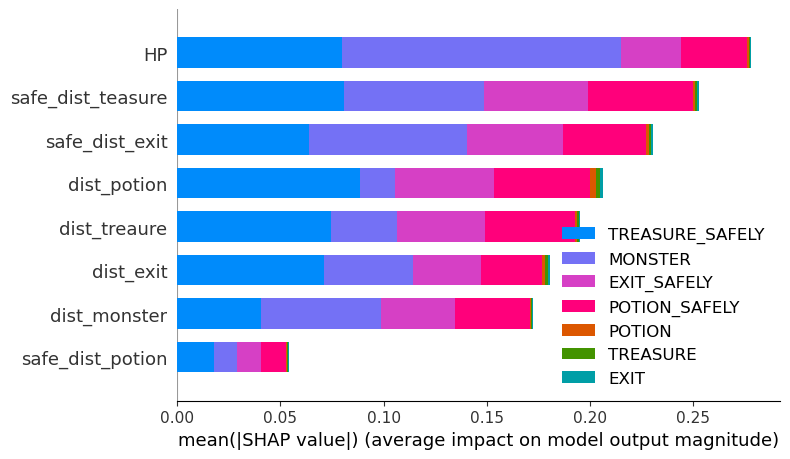

Dropdown(description='Select Label:', options=(('EXIT', 0), ('EXIT_SAFELY', 1), ('MONSTER', 2), ('POTION', 3), ('POTION_SAFELY', 4), ('TREASURE', 5), ('TREASURE_SAFELY', 6)), value=0)


In [104]:
shap.summary_plot(shap_values = kernel_shap_values, feature_names=data[obs].columns, class_names=y_data.columns, plot_type='bar')
# shap.bar_plot(shap_values = kernel_shap_values, feature_names=data[obs].columns)
print(current_label)


In [122]:
# explainer_shap_values= explainer.shap
# shap.plots.bar(explainer_shap_values[:,2])
# explainer_shap_values
kernel_shap_values[0,:]

TypeError: list indices must be integers or slices, not tuple

In [121]:
# fig, axs = plt.subplots(2,3)
shap.summary_plot(kernel_shap_values[0,:])

TypeError: list indices must be integers or slices, not tuple

In [113]:
Kernel_explainer.explain_row(x_data.iloc[0,:],max_evals=5,main_effects='',error_bounds=1, outputs=0,silent=0)

{}

In [129]:
shap.force_plot(Kernel_explainer.expected_value[0],kernel_shap_values[0],x_data.iloc[0])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed